<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

Este cuaderno forma parte del proyecto de colaboración entre IBiDat y Santander Corporation que busca estudiar la aplicabilidad de técnicas de fairness en Machine Learning (ML) en el ámbito financiero. El cuaderno proporciona un contenido principalmente práctico en el cual se aplicarán las distintas técnicas planteadas a nivel teórico en el report complementario.

## Metodologías consideradas 
Se trabajará con 8 técnicas de obtención de fairness diferentes que se agrupan en 3 categorías en función del punto en el que se apliquen dentro de un pipeline de ML:

<img src="img/plotFairness.jpg" alt="drawing" width="900"/>

**Técnicas de preprocesado:** 
* Reponderación (reweighing)
* Eliminador de impacto dispar (disparate impact remover)

**Técnicas de inprocesado**:
* Eliminador de prejuicios por regularización (prejudice remover)
* Eliminación de prejuicios adversarios (adversarial debiasing)
* Algoritmo de metafairness (metafairness algorithm)

**Técnicas de postprocesado**
* Clasificación de rechazo de opción (reject option classification)
* Escalado de Platt por grupos (group-wise Platt scaling)
* Procesasor de probabilidades igualadas (equalized odds processor)

## Evaluación de resultados

Para evaluar las diferentes metodologías se considerará un esquema común en cuanto a algoritmos, conjuntos de datos y métricas.

### Algoritmos 
Se utilizará un algoritmo tradicional y un algoritmo ML.
* Regresión logística: este es uno de los algoritmos de clasificación más utilizado por su facilidad de implementación e interpretación, y es un algoritmo que sigue en vigor en áreas de las finanzas como el credit scoring, por lo que se selecciona como un referente de las metodologías tradicionales.
* Ensemble tipo xgboost: el xgboost es un ensemble de modelos basados en árboles de decisión que se ha convertido en un estándar en multitud de industrias por la calidad de sus predicciones, por lo que se selecciona como referente de las metodologías ML.
Además de estos algoritmos, de forma puntual podrán utilizarse otros si son requeridos por una metodología concreta, como es el caso por ejemplo del algoritmo de *eliminación de prejuicios adversarios*, que se basa en el uso de redes neuronales.

### Conjuntos de datos 
Cada metodología se evaluará en dos conjuntos de datos de diferente tamaño.

| Nombre     | Tamaño muestral | Número de variables | Ratio de default | Ratio del atributo sensible |
|------------|-----------------|---------------------|------------------|-----------------------------|
| German     | 1000            | 61                  | 0.3              | 0.19                        |
| Homecredit | 307511          | 122                 | 0.08             | 0.04                        |

En ambos conjuntos de datos se considerará que el atributo sensible es la edad. Una persona pertenecerá al grupo sensible si es menor de 25 años.

### Métricas 
Cada metodología se evaluará en un conjunto de métricas que represente por un lado, la calidad predictiva del modelo, y por otro, el nivel de sesgo presente en sus predicciones. Dado que existen varias definiciones diferentes de fairness, se considerarán 3 métricas para medir el nivel de sesgo, cada una asociada a una definición.

**Calidad predictiva**
* AUC: área bajo la curva ROC
* Accuracy: $\dfrac{TP+TN}{TP+TN+FP+FN}$.
* Balanced accuracy: $\dfrac{TPR+TNR}{2}$. Métrica usada en problemas de clasificación no balanceados.

**Nivel de sesgo**: Sea $A$ la variable que denota el atributo sensible. Entonces se definen las siguientes métricas,
* Statistical parity difference (independencia): $\Pr(\hat{Y} = 1 | A = 0) - Pr(\hat{Y} = 1 | A = 1)$. Valores menores que 0 indican que el grupo privilegiado tiene una mayor proporción de predicciones positivas que el no privilegiado.
* Positive predicted value (suficiencia): $|PPV_{A = 0} - PPV_{A = 1}|$
* Average odds difference (separación): $\dfrac{|FPR_{A = 0} - FPR_{A = 1}| + |TPR_{A = 0} - TPR_{A = 1}|}{2}$

Además de estas métricas, en aquellos casos en que alguna metodología particular obtenga el fairness optimizando una métrica particular, dicha métrica también se incorporará a los resultados presentados aquí.



# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Selección de dataset.

El siguiente bloque permite seleccionar el conjunto de datos sobre el que trabajar. Debe recordarse que el conjunto de `homecredit` es mucho mayor por lo que tardará más tiempo en ejecutarse.


In [3]:

dataset_name = 'german' # valid options are: german; homecredit

if dataset_name == 'german':
    dataset_german = GermanDataset(
        protected_attribute_names=['age'],            
        privileged_classes=[lambda x: x >= 25],      
        features_to_drop=['personal_status', 'sex'] 
    )
    

    # xgboost requiere que los labels empiecen en 0, y en este conjunto empiezan en 1
    # dataset_german.labels = dataset_german.labels - 1
    # dataset_german.favorable_label = dataset_german.favorable_label - 1
    # dataset_german.unfavorable_label = dataset_german.unfavorable_label - 1
    # cambiar los labels 2 a 0 (label 2 es desfavorabel y 1 es favorable) 
    dataset_german.labels[dataset_german.labels.ravel() == 2] =  dataset_german.labels[dataset_german.labels.ravel() == 2] - 2
    dataset_german.unfavorable_label = dataset_german.unfavorable_label - 2

    
    
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_german.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_german.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_german)
    
    print(f'Dimensiones del conjunto de datos: {dataset_german.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_german.favorable_label)
    print("Label del grupo desfavorable:", dataset_german.unfavorable_label) 
    
elif dataset_name == 'homecredit':
    dataset_homecredit = pd.read_csv('data/homecredit.zip', compression='zip', header=0, sep=',', quotechar='"')

    dataset_homecredit = utils.preprocess_homecredit(dataset_homecredit)

    dataset_homecredit_aif = utils.convert_to_standard_dataset(
            df=dataset_homecredit,
            target_label_name='TARGET',
            sensitive_attribute='AGE',
            priviledged_classes=[lambda x: x >= 25],
            favorable_target_label=[1],
            features_to_keep=[],
            categorical_features=[])

    # para hacer submuestra 
    sample_size_hc = 50000
    dataset_homecredit_aif = dataset_homecredit_aif.subset(np.random.randint(0, 307511+1, size=(sample_size_hc)))
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_homecredit_aif.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_homecredit_aif.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_homecredit_aif)

    print(f'Dimensiones del conjunto de datos: {dataset_homecredit_aif.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_homecredit_aif.favorable_label)
    print("Label del grupo desfavorable:", dataset_homecredit_aif.unfavorable_label) 
else:
    print('Invalid dataset selected')

Dimensiones del conjunto de datos: (1000, 57)
Grupos privilegiados: [{'age': 1.0}]
Grupos no privilegiados: [{'age': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [4]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [5]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 12.7 ms, sys: 226 µs, total: 12.9 ms
Wall time: 11.7 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7499
Balanced accuracy: 0.7050
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.3077
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2020
Sufficiency ( |ΔPPV| ) : 0.3788
CPU times: user 163 ms, sys: 21 ms, total: 184 ms
Wall time: 170 ms


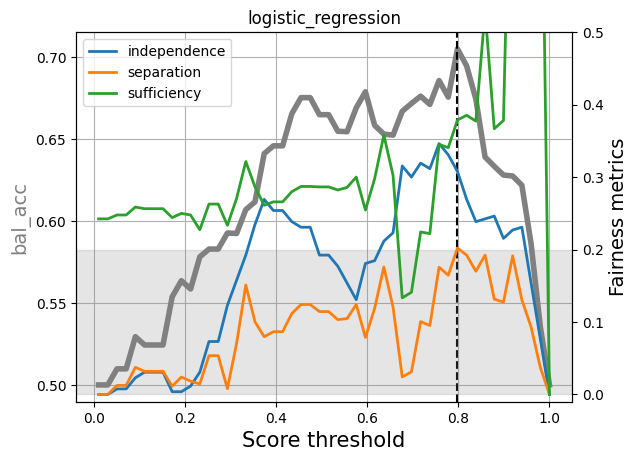

In [6]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [7]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7450
Balanced accuracy: 0.7012
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.1967
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1680
Sufficiency ( |ΔPPV| ) : 0.2579


### XGBoost

In [8]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 39min 44s, sys: 1.75 s, total: 39min 46s
Wall time: 1min 14s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7324
Balanced accuracy: 0.7005
Accuracy: 0.6800
Independence ( |ΔP(Y_pred = 1)| ): 0.2308
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0715
Sufficiency ( |ΔPPV| ) : 0.1884
CPU times: user 2.88 s, sys: 27.2 ms, total: 2.9 s
Wall time: 252 ms


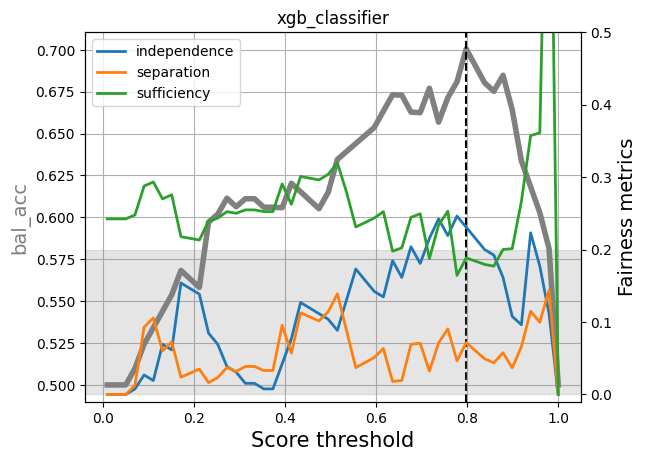

In [9]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [10]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7555
Balanced accuracy: 0.6854
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.0589
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0755
Sufficiency ( |ΔPPV| ) : 0.1909


## Técnicas de preprocesado

### Reponderación

In [11]:
%%time 
# Nombramos al modelo
fairness_method = '_reweighting'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_copy = PreProcessor.transform(data_train_copy)
data_val_copy = PreProcessor.transform(data_val_copy)
data_test_copy = PreProcessor.transform(data_test_copy)

CPU times: user 11.1 ms, sys: 0 ns, total: 11.1 ms
Wall time: 11 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7445
Balanced accuracy: 0.7031
Accuracy: 0.6644
Independence ( |ΔP(Y_pred = 1)| ): 0.2059
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1423
Sufficiency ( |ΔPPV| ) : 0.1930
CPU times: user 203 ms, sys: 4.01 ms, total: 207 ms
Wall time: 198 ms


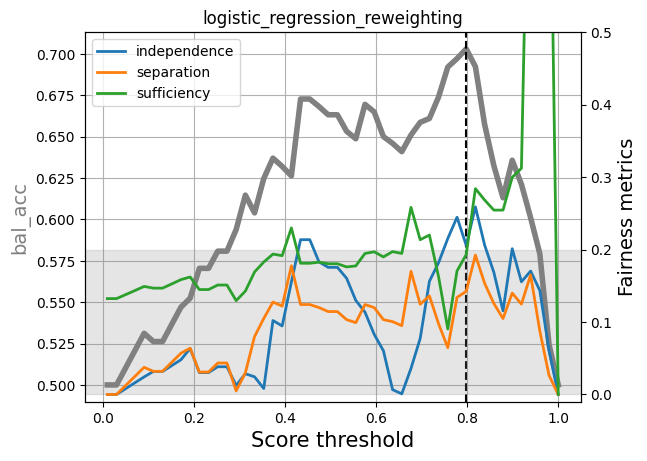

In [12]:
%%time 

# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7324
Balanced accuracy: 0.6976
Accuracy: 0.6771
Independence ( |ΔP(Y_pred = 1)| ): 0.1997
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0715
Sufficiency ( |ΔPPV| ) : 0.1009
CPU times: user 44min 38s, sys: 864 ms, total: 44min 39s
Wall time: 46.8 s


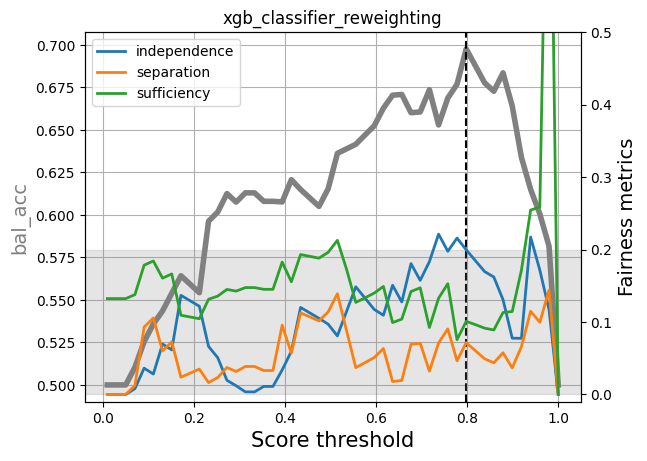

In [13]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


### Eliminador de impacto dispar

In [14]:
%%time 
# Nombramos al modelo
fairness_method = '_di_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_copy = PreProcessor.fit_transform(data_train_copy)
data_val_copy = PreProcessor.fit_transform(data_val_copy)
data_test_copy = PreProcessor.fit_transform(data_test_copy)



CPU times: user 279 ms, sys: 56.1 ms, total: 335 ms
Wall time: 334 ms


Aplicamos los métodos de regresión logística y XGBoost

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.8182
AUC: 0.7508
Balanced accuracy: 0.6854
Accuracy: 0.6600
Independence ( |ΔP(Y_pred = 1)| ): 0.3231
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1770
Sufficiency ( |ΔPPV| ) : 0.3529
CPU times: user 135 ms, sys: 4.01 ms, total: 139 ms
Wall time: 130 ms


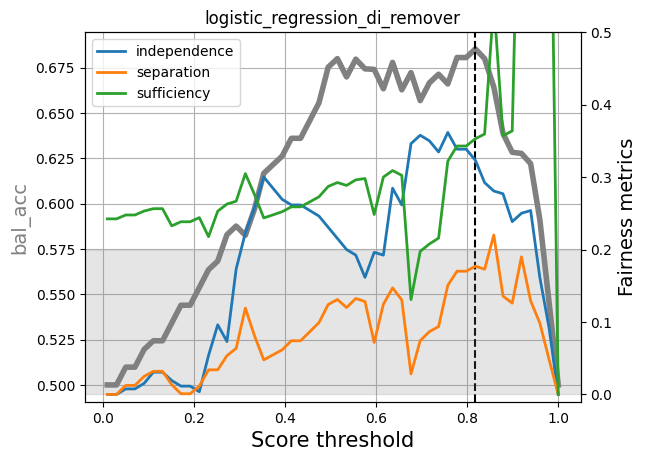

In [15]:
%%time 
# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7778
AUC: 0.7433
Balanced accuracy: 0.6916
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.2500
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1128
Sufficiency ( |ΔPPV| ) : 0.2619
CPU times: user 45min 52s, sys: 602 ms, total: 45min 53s
Wall time: 44.1 s


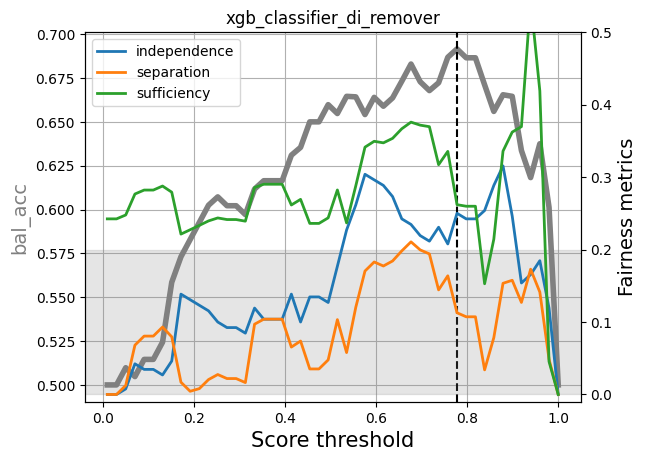

In [16]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])


# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


## Técnicas de inprocesado

### Eliminador de prejuicios por regularización

In [17]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [18]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [19]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

CPU times: user 24.6 s, sys: 1min 10s, total: 1min 34s
Wall time: 4.7 s


In [20]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep(
        dataset=data_val_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics(
        dataset=data_test_copy, 
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr
Threshold corresponding to *best balanced accuracy*: 0.5757
AUC: 0.6922
Balanced accuracy: 0.6533
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.2846
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1008
Sufficiency ( |ΔPPV| ) : 0.3250


Results for meta_fairness_fdr
Threshold corresponding to *best balanced accuracy*: 0.6363
AUC: 0.7562
Balanced accuracy: 0.7151
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.2654
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1520
Sufficiency ( |ΔPPV| ) : 0.2806


CPU times: user 1.29 s, sys: 3.26 s, total: 4.55 s
Wall time: 282 ms


### Eliminación de prejuicios adversarios

In [21]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

2024-06-13 14:32:04.224497: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-13 14:32:04.481199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 78.328941; batch adversarial loss: 0.583292
epoch 1; iter: 0; batch classifier loss: 65.280731; batch adversarial loss: 0.564662
epoch 2; iter: 0; batch classifier loss: 32.841087; batch adversarial loss: 0.517796
epoch 3; iter: 0; batch classifier loss: 38.843300; batch adversarial loss: 0.526233
epoch 4; iter: 0; batch classifier loss: 36.136955; batch adversarial loss: 0.543333
epoch 5; iter: 0; batch classifier loss: 51.421822; batch adversarial loss: 0.534629
epoch 6; iter: 0; batch classifier loss: 50.934196; batch adversarial loss: 0.572134
epoch 7; iter: 0; batch classifier loss: 40.475807; batch adversarial loss: 0.534377
epoch 8; iter: 0; batch classifier loss: 43.081650; batch adversarial loss: 0.562888
epoch 9; iter: 0; batch classifier loss: 42.964199; batch adversarial loss: 0.524322
epoch 10; iter: 0; batch classifier loss: 43.009399; batch adversarial loss: 0.545586
epoch 11; iter: 0; batch classifier loss: 37.335667; batch adver

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3737
AUC: 0.6914
Balanced accuracy: 0.6595
Accuracy: 0.6133
Independence ( |ΔP(Y_pred = 1)| ): 0.1231
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0298
Sufficiency ( |ΔPPV| ) : 0.1879
CPU times: user 147 ms, sys: 7.76 ms, total: 155 ms
Wall time: 142 ms


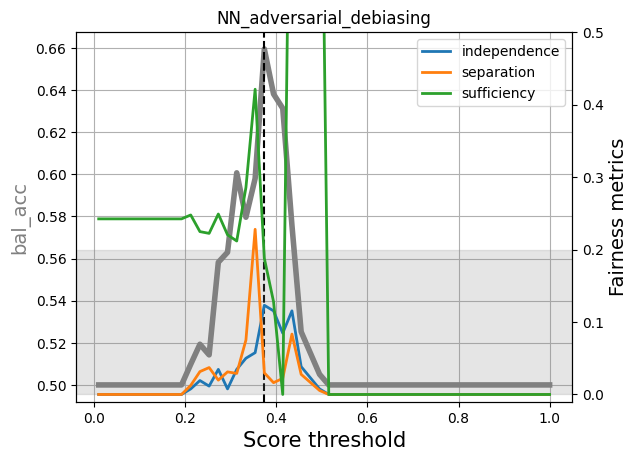

In [22]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [23]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 192.066650
epoch 1; iter: 0; batch classifier loss: 71.284561
epoch 2; iter: 0; batch classifier loss: 62.725182
epoch 3; iter: 0; batch classifier loss: 94.393906
epoch 4; iter: 0; batch classifier loss: 75.588760
epoch 5; iter: 0; batch classifier loss: 41.643898
epoch 6; iter: 0; batch classifier loss: 75.982780
epoch 7; iter: 0; batch classifier loss: 61.480770
epoch 8; iter: 0; batch classifier loss: 66.756577
epoch 9; iter: 0; batch classifier loss: 43.706657
epoch 10; iter: 0; batch classifier loss: 38.885208
epoch 11; iter: 0; batch classifier loss: 57.362366
epoch 12; iter: 0; batch classifier loss: 49.004250
epoch 13; iter: 0; batch classifier loss: 48.125507
epoch 14; iter: 0; batch classifier loss: 54.512791
epoch 15; iter: 0; batch classifier loss: 45.581505
epoch 16; iter: 0; batch classifier loss: 70.077599
epoch 17; iter: 0; batch classifier loss: 55.389221
epoch 18; iter: 0; batch classifier loss: 49.910393
epoch 19; iter: 0; ba

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.7429
Balanced accuracy: 0.6854
Accuracy: 0.6600
Independence ( |ΔP(Y_pred = 1)| ): 0.3231
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0580
Sufficiency ( |ΔPPV| ) : 0.0882
CPU times: user 369 ms, sys: 60 ms, total: 429 ms
Wall time: 412 ms


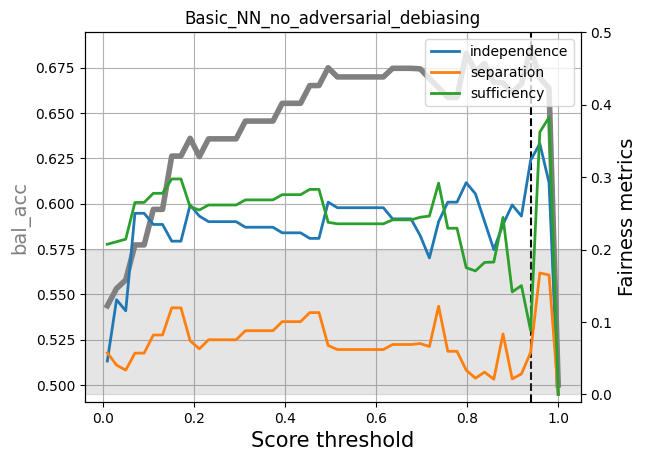

In [24]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Técnicas de postprocesado 

### Clasificación de rechazo de opción

In [25]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 11.6 s, sys: 4.62 s, total: 16.3 s
Wall time: 10.5 s


In [26]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.6831
AUC: 0.7499
Balanced accuracy: 0.6765
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.0038
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0898
Sufficiency ( |ΔPPV| ) : 0.2996


logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.7128
AUC: 0.7499
Balanced accuracy: 0.6762
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.1462
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1554
Sufficiency ( |ΔPPV| ) : 0.3451


logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.7227
AUC: 0.7499
Balanced accuracy: 0.6958
Accuracy: 0.6800
Independence ( |ΔP(Y_pred = 1)| ): 0.2462
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0645
Sufficiency ( |ΔPPV| ) : 0.1784




In [27]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 13.8 s, sys: 96.1 ms, total: 13.9 s
Wall time: 9.91 s


In [28]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.4753
AUC: 0.7324
Balanced accuracy: 0.6438
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.1385
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0900
Sufficiency ( |ΔPPV| ) : 0.3023


xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5643
AUC: 0.7324
Balanced accuracy: 0.6438
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.0346
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1543
Sufficiency ( |ΔPPV| ) : 0.3362


xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5643
AUC: 0.7324
Balanced accuracy: 0.6438
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.0346
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1543
Sufficiency ( |ΔPPV| ) : 0.3362




### Escalado de Platt por grupos

In [29]:
%%time
fairness_method = '_platt_scaling'
model_names = ['logistic_regression', 'xgb_classifier']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores(
            dataset_true = data_val_copy,
            dataset_preds = data_val_preds2,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.7426
AUC: 0.7623
Balanced accuracy: 0.7145
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.5077
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2222
Sufficiency ( |ΔPPV| ) : 0.8788

Validation set results for xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.7376
AUC: 0.7447
Balanced accuracy: 0.6999
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.5308
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2028
Sufficiency ( |ΔPPV| ) : 0.8551
CPU times: user 2.56 s, sys: 196 ms, total: 2.76 s
Wall time: 277 ms


In [30]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

### Procesador de probabilidades igualadas

#### Usando labels

In [31]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [32]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [33]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [34]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [35]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 117 ms, sys: 1.01 s, total: 1.13 s
Wall time: 26.8 ms


In [36]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.7499
Balanced accuracy: 0.6842
Accuracy: 0.7400
Independence ( |ΔP(Y_pred = 1)| ): 0.2115
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0828
Sufficiency ( |ΔPPV| ) : 0.2525


Results for logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.5959
AUC: 0.7499
Balanced accuracy: 0.5971
Accuracy: 0.7067
Independence ( |ΔP(Y_pred = 1)| ): 0.3731
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0352
Sufficiency ( |ΔPPV| ) : 0.1795


Results for logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7499
Balanced accuracy: 0.7050
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.3077
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2020
Sufficiency ( |ΔPPV| ) : 0.3788




In [37]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 5.18 s, sys: 139 ms, total: 5.32 s
Wall time: 99.3 ms


In [38]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.7171
AUC: 0.7324
Balanced accuracy: 0.6771
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.2154
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0322
Sufficiency ( |ΔPPV| ) : 0.1875


Results for xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.6363
AUC: 0.7324
Balanced accuracy: 0.6783
Accuracy: 0.7133
Independence ( |ΔP(Y_pred = 1)| ): 0.1923
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0235
Sufficiency ( |ΔPPV| ) : 0.2000


Results for xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7324
Balanced accuracy: 0.7005
Accuracy: 0.6800
Independence ( |ΔP(Y_pred = 1)| ): 0.2308
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0715
Sufficiency ( |ΔPPV| ) : 0.1884




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [39]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.797959,0.704991,0.673333,0.307692,0.202020,0.378788,0.749851
xgb_classifier,0.797959,0.700535,0.680000,0.230769,0.071465,0.188406,0.732422
logistic_regression_reweighting,0.797959,0.703106,0.664399,0.205864,0.142298,0.192992,0.744504
xgb_classifier_reweighting,0.797959,0.697587,0.677109,0.199672,0.071465,0.100892,0.732422
logistic_regression_di_remover,0.818163,0.685383,0.660000,0.323077,0.177020,0.352941,0.750842
xgb_classifier_di_remover,0.777755,0.691622,0.693333,0.250000,0.112753,0.261905,0.743316
meta_fairness_sr,0.575714,0.653298,0.686667,0.284615,0.100758,0.325000,0.692216
meta_fairness_fdr,0.636327,0.715092,0.686667,0.265385,0.152020,0.280597,0.756189
NN_adversarial_debiasing,0.373673,0.659537,0.613333,0.123077,0.029798,0.187879,0.691424
Basic_NN_no_adversarial_debiasing,0.939388,0.685383,0.660000,0.323077,0.057955,0.088235,0.742919


### Resultados en test

In [40]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.797959,0.701152,0.640000,0.196650,0.168031,0.257862,0.744999
xgb_classifier,0.797959,0.685391,0.640000,0.058933,0.075528,0.190909,0.755506
logistic_regression_reweighting,0.797959,0.687134,0.618643,0.049310,0.067867,0.096757,0.733684
xgb_classifier_reweighting,0.797959,0.687116,0.639750,0.029881,0.075528,0.110512,0.755506
logistic_regression_di_remover,0.818163,0.676702,0.600000,0.178660,0.182776,0.334783,0.744797
xgb_classifier_di_remover,0.777755,0.734896,0.706667,0.139578,0.036358,0.092308,0.774500
meta_fairness_sr,0.575714,0.616791,0.646667,0.218983,0.192961,0.298108,0.653869
meta_fairness_fdr,0.636327,0.710750,0.660000,0.143921,0.094583,0.160714,0.728430
NN_adversarial_debiasing,0.373673,0.660639,0.606667,0.065136,0.184895,0.346405,0.716306
Basic_NN_no_adversarial_debiasing,0.939388,0.675490,0.626667,0.368486,0.257622,0.550000,0.743585


In [41]:
algorithm_performance_summary.to_csv('PERFORMANCE_GERMAN_SIMPLE', index = True, sep=',', encoding='utf-8')